In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
import nltk
nltk.download('punkt')  # Download the punkt tokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def check_claim_similarity(evidence, claim, threshold=0.85):
    """
    Compares the semantic similarity between an evidence and a claim using BERT embeddings.

    Parameters:
        evidence (str): The text evidence to support or refute the claim.
        claim (str): The claim statement to be evaluated.
        threshold (float): Similarity score threshold to determine if the claim is likely true.

    Returns:
        str: Outcome of the claim verification (true or false).
        float: Calculated similarity score.
        str: Portion of the evidence refuting the claim (if applicable).
        float: L1 norm between evidence and claim embeddings
        float: L2 norm between evidence and claim embeddings
        float: Jaccard index between evidence and claim embeddings
    """

    # Tokenize the evidence and claim
    inputs_evidence = tokenizer(evidence, return_tensors="pt", max_length=512, truncation=True)
    inputs_claim = tokenizer(claim, return_tensors="pt", max_length=512, truncation=True)

    # Get embeddings for evidence and claim by averaging hidden states
    with torch.no_grad():
        outputs_evidence = model(**inputs_evidence, output_hidden_states=True)
        outputs_claim = model(**inputs_claim, output_hidden_states=True)

    # Get the last hidden state and average it to obtain a single embedding for each
    evidence_embedding = outputs_evidence.hidden_states[-1].mean(dim=1).cpu().numpy()
    claim_embedding = outputs_claim.hidden_states[-1].mean(dim=1).cpu().numpy()

    # Calculate cosine similarity, L1 norm, L2 norm, and Jaccard Index
    similarity_score = cosine_similarity(evidence_embedding, claim_embedding)[0][0]
    l1_norm = np.linalg.norm(evidence_embedding - claim_embedding, ord=1)
    l2_norm = np.linalg.norm(evidence_embedding - claim_embedding, ord=2)

    # Assuming binary embeddings for Jaccard Index
    intersection = np.sum(evidence_embedding * claim_embedding)
    union = np.sum(evidence_embedding) + np.sum(claim_embedding) - intersection
    jaccard_index = intersection / (union + 1e-10)  # Avoid division by zero

    # Interpret similarity score
    is_claim_true = similarity_score >= threshold
    result = "Claim is likely true." if is_claim_true else "Claim is likely false."

    # If the claim is likely false, identify the portion of evidence contributing to the low similarity
    refuting_part = ""
    if not is_claim_true:
        # Split evidence into sentences
        sentences = nltk.sent_tokenize(evidence)

        # Calculate similarity for each sentence
        sentence_similarities = []
        for sentence in sentences:
            inputs_sentence = tokenizer(sentence, return_tensors="pt", max_length=512, truncation=True)
            with torch.no_grad():
                outputs_sentence = model(**inputs_sentence, output_hidden_states=True)
            sentence_embedding = outputs_sentence.hidden_states[-1].mean(dim=1).cpu().numpy()
            sentence_similarity = cosine_similarity(sentence_embedding, claim_embedding)[0][0]
            sentence_similarities.append((sentence, sentence_similarity))

        # Find the sentence with the lowest similarity score
        refuting_sentence = min(sentence_similarities, key=lambda x: x[1])
        refuting_part = refuting_sentence[0]  # Get the refuting sentence with the lowest similarity

    return result, similarity_score, refuting_part, l1_norm, l2_norm, jaccard_index


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Usage example with user-provided inputs
evidence_input = input("Enter evidence: ")
claim_input = input("Enter claim: ")
result, score, refuting_part, l1, l2, jaccard = check_claim_similarity(evidence_input, claim_input)

Enter evidence:  This claim originated from a now-retracted 1998 study by Andrew Wakefield, which suggested a link between the MMR vaccine and autism. Extensive research since then, including large studies by the Centers for Disease Control and Prevention (CDC), the World Health Organization (WHO), and the Institute of Medicine, has shown no credible evidence linking vaccines to autism. Wakefield’s study was found to have manipulated data, leading to his medical license being revoked.
Enter claim: Vaccines cause autism.


In [ ]:
print(result)
print(f"Similarity Score: {score}")
print(f"Refuting evidence (if any): {refuting_part}")
print(f"L1 Norm: {l1}")
print(f"L2 Norm: {l2}")
print(f"Jaccard Index: {jaccard}")

Claim is likely false.
Similarity Score: 0.5058029890060425
Refuting evidence (if any): Wakefield’s study was found to have manipulated data, leading to his medical license being revoked.
L1 Norm: 2.666825771331787
L2 Norm: 9.087715148925781
Jaccard Index: -0.6638035879325792


In [ ]:
# Define the column width for alignment
print(f"| {'Metric':<20} | {'Value':<20} |")
print(f"|{'-' * 22}|{'-' * 22}|")
print(f"| {'Result':<20} | {result:<20} |")
print(f"| {'Similarity Score':<20} | {score:<20} |")
print(f"| {'Refuting Evidence':<20} | {refuting_part:<20} |")
print(f"| {'L1 Norm':<20} | {l1:<20} |")
print(f"| {'L2 Norm':<20} | {l2:<20} |")
print(f"| {'Jaccard Index':<20} | {jaccard:<20} |")


| Metric               | Value                |
|----------------------|----------------------|
| Result               | Claim is likely false. |
| Similarity Score     | 0.5058029890060425   |
| Refuting Evidence    | Wakefield’s study was found to have manipulated data, leading to his medical license being revoked. |
| L1 Norm              | 2.666825771331787    |
| L2 Norm              | 9.087715148925781    |
| Jaccard Index        | -0.6638035879325792  |


In [ ]:
thresholds = np.arange(0.1, 1.0, 0.05)
similarities = []
for threshold in thresholds:
    result, similarity_score, _, _, _, _ = check_claim_similarity(evidence_input, claim_input, threshold)
    similarities.append(similarity_score)

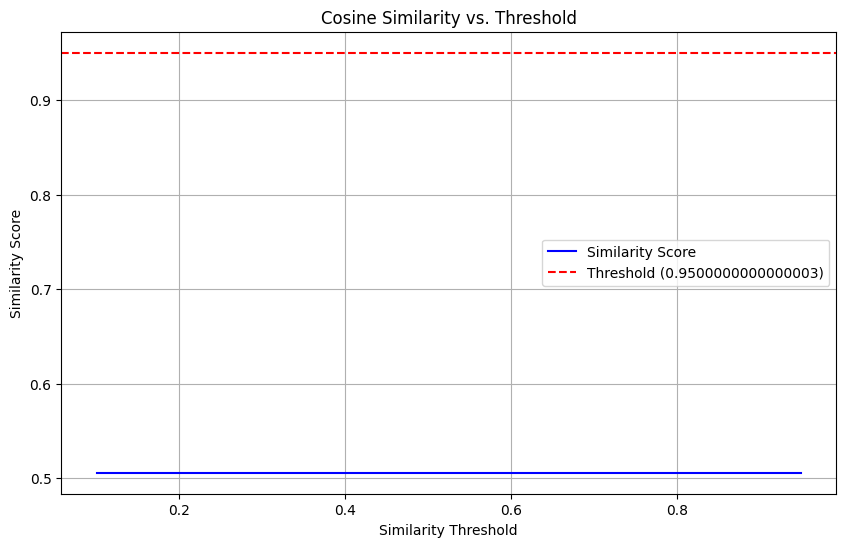

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, similarities, label="Similarity Score", color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold ({threshold})")
plt.xlabel("Similarity Threshold")
plt.ylabel("Similarity Score")
plt.title("Cosine Similarity vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
evidence_samples = [
    "The Earth orbits the Sun.",
    "Water boils at 100°C at sea level.",
    "Cats are mammals.",
    "The capital of France is Paris.",
    "Bananas are rich in potassium."
]
claim_samples = [
    "The Earth revolves around the Sun.",
    "Water freezes at 0°C.",
    "Cats belong to the animal kingdom.",
    "Paris is the capital of France.",
    "Potassium is found in bananas."
]

# Calculate metrics for multiple pairs
similarities = []
l1_norms, l2_norms, jaccard_indices = [], [], []

for evidence, claim in zip(evidence_samples, claim_samples):
    result, similarity_score, _, l1, l2, jaccard = check_claim_similarity(evidence, claim)
    similarities.append(similarity_score)
    l1_norms.append(l1)
    l2_norms.append(l2)
    jaccard_indices.append(jaccard)

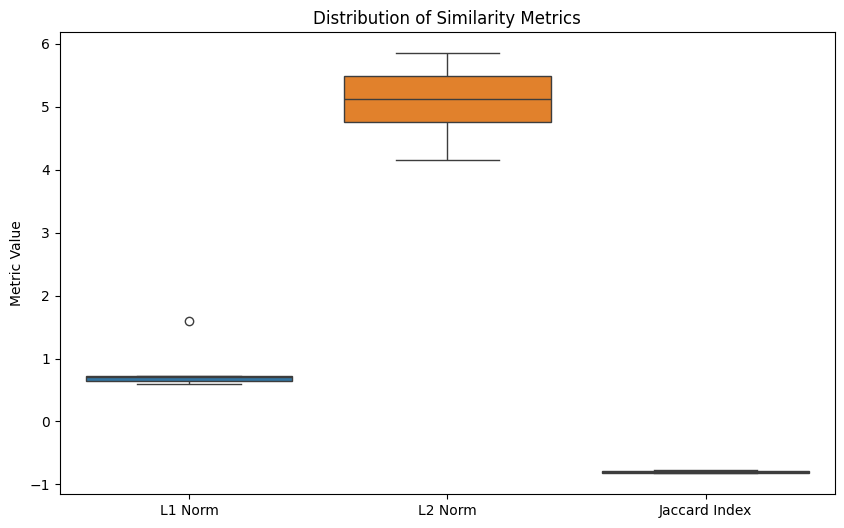

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=[l1_norms, l2_norms, jaccard_indices])  # Removed 'labels' argument
plt.title("Distribution of Similarity Metrics")
plt.ylabel("Metric Value")
plt.xticks([0, 1, 2], ['L1 Norm', 'L2 Norm', 'Jaccard Index'])  # Manually add labels
plt.show()

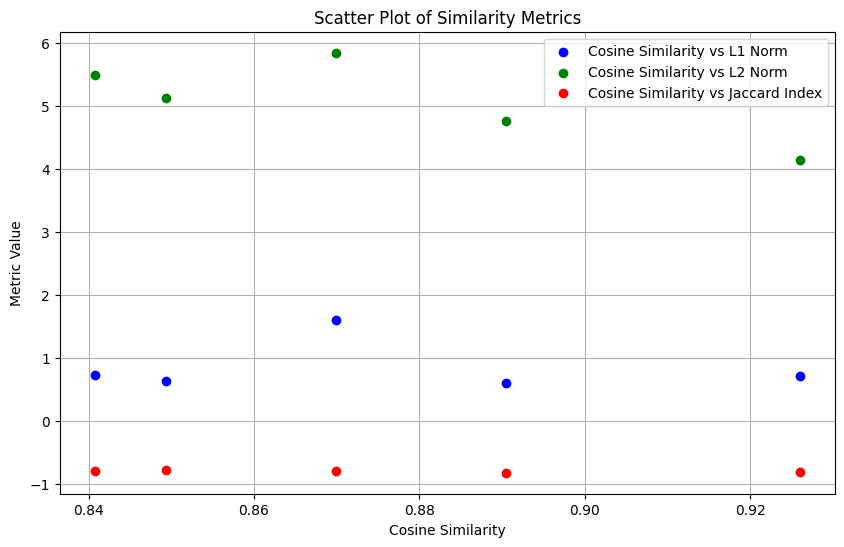

In [ ]:
# 3. Scatter Plot of Similarity Metrics (Cosine Similarity vs. L1 Norm, L2 Norm, and Jaccard)
plt.figure(figsize=(10, 6))
plt.scatter(similarities, l1_norms, label='Cosine Similarity vs L1 Norm', color='blue')
plt.scatter(similarities, l2_norms, label='Cosine Similarity vs L2 Norm', color='green')
plt.scatter(similarities, jaccard_indices, label='Cosine Similarity vs Jaccard Index', color='red')
plt.xlabel("Cosine Similarity")
plt.ylabel("Metric Value")
plt.title("Scatter Plot of Similarity Metrics")
plt.legend()
plt.grid(True)
plt.show()
